<a href="https://colab.research.google.com/github/Ethel-Ogallo/multitask_regression_deeplearning/blob/master/Multi_task_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-Task Regression Using ResNet50

This notebook demonstrates a **supervised multi-task regression** workflow for remote sensing using **TorchGeo** using the Digital Typhoon dataset, which consists of infrared (IR) satellite imagery of tropical cyclones paired with meteorological measurements.

The objective is to predict multiple continuous typhoon intensity variables from satellite imagery using a deep learning model.  

### Dataset Overview
The [Digital Typhoon](https://torchgeo.readthedocs.io/en/stable/api/datasets.html#digital-typhoon) is derived from hourly infrared channel observations captured by multiple generations of the Himawari meteorological satellites, spanning the period from 1978. The satellite measurements have been converted to brightness temperatures and normalized across different sensors, resulting in a consistent spatio-temporal dataset covering more than four decades.  

**Dataset features:**
- Infrared (IR) satellite imagery of 512 × 512 pixels at ~5km resolution
- Auxiliary metadata including wind speed, pressure and additional typhoon-related attributes  
- 1,099 typhoons and 189,364 images

**References**  
1. Machine Learning for the Digital Typhoon Dataset:
Extensions to Multiple Basins and New Developments
in Representations and Tasks: [arXiv:2411.16421](https://arxiv.org/pdf/2411.16421)  
2. Digital Typhoon: Long-term Satellite Image Dataset
for the Spatio-Temporal Modeling of Tropical Cyclones: [arXiv:2311.02665](https://arxiv.org/pdf/2311.02665)

*notes from paper:*  
*the images feature a 2D array of brightness temperatures around the typhoon’s center, formatted in HDF5*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install torchgeo --quiet
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 14.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 51.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 44.2 MB/s eta 0:00:00


In [2]:
## import package
import os
import shutil
import pandas as pd
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from datetime import datetime
import time

import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import MeanAbsoluteError

from torchvision import transforms
from torchvision import models
from torchvision.transforms import Resize

from torchgeo.datasets import DigitalTyphoon
from torchgeo.datamodules import DigitalTyphoonDataModule
from torchgeo.trainers import RegressionTask
from torchgeo.models import resnet50, ResNet50_Weights

import lightning.pytorch as pl
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor, RichProgressBar
from lightning.pytorch.loggers import WandbLogger
import wandb

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [ ]:
# load dataset
root = "/home/ogallo/DL4CV/DigitalTyphoon"

dataset = DigitalTyphoon(
    root=root,
    features=["wind", "pressure"],
    targets=["wind", "pressure"],
    sequence_length=1,
    download=False
)


In [ ]:
aux_data = pd.read_csv("/home/ogallo/DL4CV/DigitalTyphoon/WP/aux_data.csv")
print(aux_data.head())     # inspect auxiliary data

       id                   image_path  year  month  day  hour  grade    lat  \
0  197830  1978120100-197830-GMS1-1.h5  1978     12    1     0      6  36.00   
1  197830  1978120103-197830-GMS1-1.h5  1978     12    1     3      6  37.46   
2  197830  1978120106-197830-GMS1-1.h5  1978     12    1     6      6  39.00   
3  197901  1978123112-197901-GMS1-1.h5  1978     12   31    12      2   2.00   
4  197901  1978123116-197901-GMS1-1.h5  1978     12   31    16      2   2.30   

      lng  pressure  wind  dir50  long50  short50  dir30  long30  short30  \
0  174.00     996.0   0.0      0       0        0      0       0        0   
1  176.44     994.0   0.0      0       0        0      0       0        0   
2  179.00     992.0   0.0      0       0        0      0       0        0   
3  172.00    1004.0   0.0      0       0        0      0       0        0   
4  171.81    1002.7   0.0      0       0        0      0       0        0   

   landfall  intp  
0         0     0  
1         0     

#### Subset the dataset
This is based on the typhoon event. We choose 1% of the typhoons i.e. 100 and then stratify teh images based on grade and lifecycle??

In [ ]:
# Import the sampling functions
from sample_v2 import load_data, sample_typhoons, sample_images, copy_images, save_sampled_data, copy_metadata

# Set paths and parameters
root = "/home/ogallo/DL4CV/DigitalTyphoon/WP"
output_dir = "/home/ogallo/DL4CV/WP_sampled_10pct"
total_typhoons = 110

# Load data
df = load_data(root)
print(f"Loaded {len(df)} records from {df['id'].nunique()} typhoons.")
print(f"Year range: {df['year'].min()} - {df['year'].max()}")

# Sample typhoons (distributed across years)
sampled_typhoons = sample_typhoons(df, total_typhoons, seed=42)
print(f"\nSelected {len(sampled_typhoons)} typhoons.")

# Sample all images for selected typhoons (no cap)
df_sampled = sample_images(df, sampled_typhoons)
print(f"Sampled {len(df_sampled)} images across {df_sampled['id'].nunique()} typhoons.")

# Copy images
copied, not_found = copy_images(df_sampled, root, output_dir)
print(f"\nCopied {copied}/{len(df_sampled)} images.")
if not_found:
    print(f"Warning: {len(not_found)} images not found.")

# Save sampled data
save_sampled_data(df_sampled, output_dir)
print(f"Saved aux_data.csv")

# Copy metadata
sampled_typhoon_ids = sorted(df_sampled['id'].unique())
copy_metadata(root, output_dir, sampled_typhoon_ids)
print(f"Copied and filtered metadata.")

Loaded 189364 records from 1099 typhoons.
Year range: 1978 - 2022

Selected 110 typhoons.
Sampled 18686 images across 110 typhoons.

Copied 18686/18686 images.
Saved aux_data.csv
Copied and filtered metadata.


## start colab

In [3]:
dataset = DigitalTyphoon(
    root="/kaggle/input/wp-10pct-sample/WP_sampled_10pct",
    features=["wind", "pressure"],
    targets=["wind", "pressure"],
    sequence_length=1,
    download=False
)

In [4]:
dataset.__len__
dataset.__getitem__(index=0)

{'image': tensor([[[0.9183, 0.8847, 0.8538,  ..., 0.9072, 0.9146, 0.8961],
          [0.9292, 0.9292, 0.9292,  ..., 0.9219, 0.9146, 0.8961],
          [0.9328, 0.9292, 0.9292,  ..., 0.9146, 0.8998, 0.8809],
          ...,
          [0.8733, 0.8809, 0.9035,  ..., 0.2863, 0.2863, 0.2754],
          [0.8961, 0.9035, 0.9183,  ..., 0.2754, 0.2863, 0.2643],
          [0.9146, 0.9219, 0.9183,  ..., 0.2754, 0.2754, 0.2754]]]),
 'wind': tensor(-1.1465),
 'pressure': tensor(1.0046),
 'label': tensor([-1.1465,  1.0046])}

In [ ]:
# sample = dataset.__getitem__(index=0)
# dataset.plot(sample)

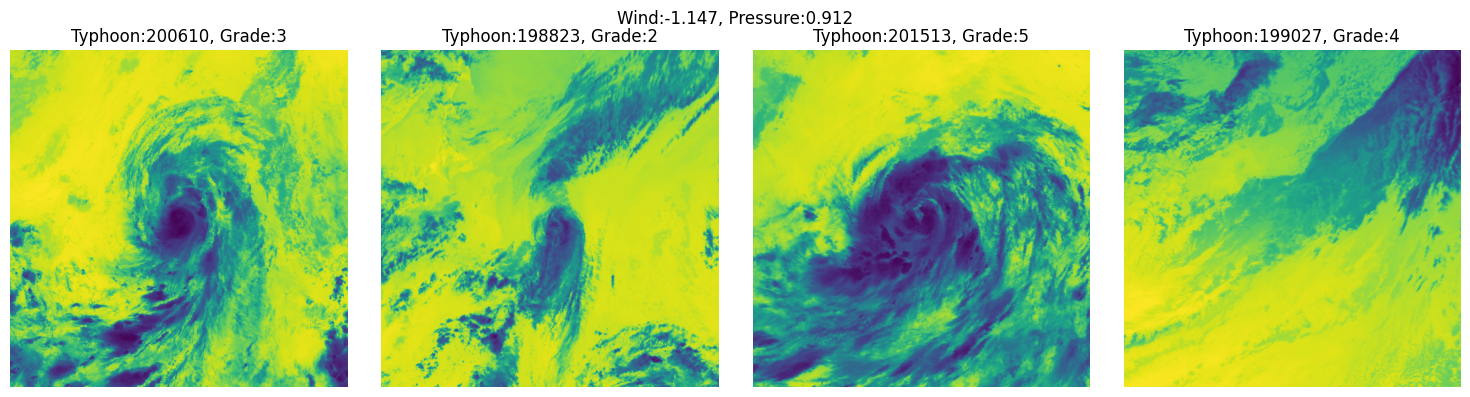

In [6]:
# visualize input
aux_df = pd.read_csv("/kaggle/input/wp-10pct-sample/WP_sampled_10pct/WP/aux_data.csv")
aux_df = aux_df.reset_index(drop=True)

# random indices
indices = np.random.choice(len(dataset), size=4, replace=False)

plt.figure(figsize=(15, 4))
for i, idx in enumerate(indices):
    sample = dataset[idx]
    image = sample['image'].squeeze()
    wind = sample['wind']
    pressure = sample['pressure']

    row = aux_df.iloc[idx] # Lookup metadata from aux_df
    typhoon_id = row['id']
    grade = row['grade']

    plt.subplot(1, 4, i + 1)
    plt.imshow(image, cmap='viridis')
    plt.title(f"Typhoon:{typhoon_id}, Grade:{grade}")
    plt.suptitle(f"Wind:{wind:.3f}, Pressure:{pressure:.3f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### ResNet50
understand and explain model architecture with 2 head for multitask regression (add pic/infograph if possible)

in markdown also include what we will do train, val and test then tuning???
 we resize from 512x512 to 224x224 , resnet default + memory issues

**wandb logger?? torchgeo.logger......

In [6]:
# # set seed
# def set_seed(seed=42):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)                # CPU
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed)       # Single GPU
#         torch.cuda.manual_seed_all(seed)   # Multi-GPU
# set_seed(42)

# # Make CUDA deterministic
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False


### Data Prep: normalize data and resize images

In [5]:
#set seed
pl.seed_everything(42)

# transform images 
def typhoon_transform(sample):
    img = sample["image"]
    if img.shape[0] == 1:
        img = img.repeat(3, 1, 1)  # from 1 channel to 3
    img = transforms.Resize(256, antialias=True)(img) # resize
    img = transforms.CenterCrop(224)(img)
    img = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )(img)    # normalize using imagenet stats
    sample["image"] = img
    return sample


# Pass it directly → applies to train + val + test
datamodule = DigitalTyphoonDataModule(
    split_by='typhoon_id',
    batch_size=16,
    num_workers=4,
    root="/kaggle/input/wp-10pct-sample/WP_sampled_10pct",
    task="regression",
    features=["wind", "pressure"],
    targets=["wind", "pressure"],
    sequence_length=1,
    download=False,
    transforms=typhoon_transform,   
)

Seed set to 42


In [7]:
# Make sure everything is loaded
datamodule.prepare_data()
datamodule.setup(stage="fit")  # creates train/val datasets

# Check dataloader output
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))

print("Batch keys:", batch.keys())                    
print("Image shape:", batch["image"].shape)           
print("Image dtype:", batch["image"].dtype)          

Batch keys: dict_keys(['image', 'wind', 'pressure', 'label'])
Image shape: torch.Size([16, 3, 224, 224])
Image dtype: torch.float32


Train base model with deafult parameters  
adapt model to have 2 heads for each target instead of teh classification head

In [13]:
class RegressionTwoHead(pl.LightningModule):
    def __init__(
        self,
        learning_rate: float = 3e-4,
        pretrained: bool = True,
        freeze_backbone: bool = True,
        dropout_rate: float = 0.3,
        head_hidden_size: int = 512,
        loss_weight_wind: float = 1.0,
        loss_weight_pressure: float = 1.0,
    ):
        """
        Two-head ResNet50 for wind speed + central pressure regression.
        - Pretrained ImageNet V2 backbone
        - Deeper heads with BN + Dropout
        - MAE metrics only (most relevant for typhoon intensity)
        - Weighted MSE + scheduler
        """
        super().__init__()
        self.save_hyperparameters()

        # --- Backbone ---
        # weights = ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        weights = ResNet50_Weights.SENTINEL2_RGB_MOCO if pretrained else None
        backbone = resnet50(weights=weights)
        
        if freeze_backbone and pretrained:
            for param in backbone.parameters():
                param.requires_grad = False
        
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        self.flatten = nn.Flatten()
        feature_size = 2048

        # --- Heads ---
        def make_head():
            return nn.Sequential(
                nn.Linear(feature_size, head_hidden_size),
                nn.BatchNorm1d(head_hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(head_hidden_size, 256),
                nn.ReLU(),
                nn.Dropout(dropout_rate * 0.5),
                nn.Linear(256, 1)
            )
        
        self.head_wind = make_head()
        self.head_pressure = make_head()

        # --- Loss & Metrics  ---
        self.criterion = nn.MSELoss()
        
        self.train_mae_wind    = MeanAbsoluteError()
        self.train_mae_pressure = MeanAbsoluteError()
        self.val_mae_wind      = MeanAbsoluteError()
        self.val_mae_pressure  = MeanAbsoluteError()

        self.loss_weight_wind    = loss_weight_wind
        self.loss_weight_pressure = loss_weight_pressure

    def forward(self, x):
        features = self.backbone(x)
        features = self.flatten(features)
        wind     = self.head_wind(features)
        pressure = self.head_pressure(features)
        return torch.cat([wind, pressure], dim=1)

    def _shared_step(self, batch, stage: str = "train"):
        imgs = batch["image"]
        wind_true  = batch["wind"]
        press_true = batch["pressure"]
        
        preds = self(imgs)  # [B, 2]
        
        # Handle possible extra dimension in targets
        if wind_true.dim() > 1:
            wind_true = wind_true.squeeze(-1)
        if press_true.dim() > 1:
            press_true = press_true.squeeze(-1)
        
        loss_wind    = self.criterion(preds[:, 0], wind_true)
        loss_pressure = self.criterion(preds[:, 1], press_true)
        
        total_loss = (
            self.loss_weight_wind * loss_wind +
            self.loss_weight_pressure * loss_pressure
        )
        
        # Update MAE metrics
        getattr(self, f"{stage}_mae_wind")(preds[:, 0], wind_true)
        getattr(self, f"{stage}_mae_pressure")(preds[:, 1], press_true)
        
        # Logging
        self.log_dict({
            f"{stage}_loss": total_loss,
            f"{stage}_loss_wind": loss_wind,
            f"{stage}_loss_pressure": loss_pressure,
            f"{stage}_mae_wind": getattr(self, f"{stage}_mae_wind"),
            f"{stage}_mae_pressure": getattr(self, f"{stage}_mae_pressure"),
        }, on_step=(stage == "train"), on_epoch=True, prog_bar=True)
        
        return total_loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, "val")

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=1e-5
        )
        
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=3,
            # verbose=True,
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

## instantiate model
model = RegressionTwoHead(
    learning_rate=3e-4,
    pretrained=True,
    freeze_backbone=True,
    dropout_rate=0.25,            
    head_hidden_size=512,
    loss_weight_wind=1.0,
    loss_weight_pressure=1.0,
)  

In [19]:
# Set WANDB key from Kaggle secrets
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["WANDB_API_KEY"] = user_secrets.get_secret("WANDB_API_KEY")


def train_model(
    model: pl.LightningModule,
    datamodule: pl.LightningDataModule,
    max_epochs: int = 30,
    patience: int = 6,
    learning_rate: float = 3e-4,
    use_wandb=True, 
    model_name: str = "resnet50_typhoon",
    project_name: str = "DigitalTyphoon",
):
    """
    Train the model with WandB logging, early stopping, checkpointing,
    and learning rate monitoring.
    """

    # Create a descriptive run name
    run_name = (
        f"{model_name}_"
        f"lr{learning_rate:.0e}_"
        f"freeze{model.hparams.freeze_backbone}_"
        f"drop{model.hparams.dropout_rate}_"
        f"epochs{max_epochs}"
    )

    # WandB Logger
    if use_wandb:
        wandb_logger = WandbLogger(
            project=project_name,
            name=run_name,
            log_model="all",       # saves best + last model
            # config=model.hparams,
            mode="online"           
        )
    else:
        wandb_logger = None

    # Callbacks
    callbacks = [
        # EarlyStopping(
        #     monitor="val_loss",
        #     patience=patience,
        #     mode="min",
        #     verbose=True,
        #     min_delta=0.001
        # ),
        ModelCheckpoint(
            monitor="val_loss",
            mode="min",
            save_top_k=1,
            filename=f"{model_name}-{{epoch:03d}}-{{val_loss:.2f}}-{{val_mae_wind:.1f}}",
            dirpath=f"checkpoints/{model_name}",
            auto_insert_metric_name=False,
        ),
        LearningRateMonitor(logging_interval="epoch")
        # RichProgressBar()  # nice progress bar
    ]

    # Trainer
    trainer = Trainer(
        max_epochs=max_epochs,
        accelerator="auto",
        devices=1,
        precision="16-mixed",
        logger=wandb_logger,
        callbacks=callbacks,
        log_every_n_steps=10,
        enable_progress_bar=True
    )

    print(f"Starting training run: {run_name}")
    print(f"WandB project: {project_name}")
    print(f"Logging online: {use_wandb}")

    # Train
    start_time = time.time()

    trainer.fit(model, datamodule=datamodule)

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Training time: {elapsed/60:.2f} minutes")

    wandb.finish()

    return trainer

# ---
trainer = train_model(
    model=model,
    datamodule=datamodule,
    max_epochs=20,
    patience=0,
    learning_rate=3e-4,
    model_name="resnet50_typhoon_v2",
    project_name="DigitalTyphoon"
)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Starting training run: resnet50_typhoon_v2_lr3e-04_freezeTrue_drop0.25_epochs20
WandB project: DigitalTyphoon
Logging online: True


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /kaggle/working/checkpoints/resnet50_typhoon_v2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name               ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone           │ Sequential        │ 23.5 M │ train │     0 │
│ 1 │ flatten            │ Flatten           │      0 │ train │     0 │
│ 2 │ head_wind          │ Sequential        │  1.2 M │ train │     0 │
│ 3 │ head_pressure      │ Sequential        │  1.2 M │ train │     0 │
│ 4 │ criterion          │ MSELoss           │      0 │ train │     0 │
│ 5 │ train_mae_wind     │ MeanAbsoluteError │      0 │ train │     0 │
│ 6 │ train_mae_pressure │ MeanAbsoluteError │      0 │ train │     0 │
│ 7 │ val_mae_wind       │ MeanAbsoluteError │      0 │ train │     0 │
│ 8 │ val_mae_pressure   │ MeanAbsoluteError │      0 │ train │     0 │
└───┴────────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 25.9 M                                                                                               
Total estimated model params size (MB): 103                                                                        
Modules in train mode: 240                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


Training time: 49.61 minutes


epoch,▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▆▇▇▇▇▇▇▇▇▇█████
lr-AdamW,█████▄▄▄▄▂▂▂▂▁▁▁▁▁▁▁
train_loss_epoch,█▇▆▅▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁
train_loss_pressure_epoch,█▇▆▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train_loss_pressure_step,▇▄▃▂██▂▁▃▅▃▄▃▃▄▅▂▁▃▂▂▄▂▁▁▃▂▃▃▂▁▁▃▃▄▃▁▂▃▇
train_loss_step,▅▂▄▆▂▇▃▄▂▄▃▄▂▃█▂▃▂▄▃▂▁▁▃▂▁▂▁▂▁▁▃▁▃▂▁▁▁▂▁
train_loss_wind_epoch,█▇▆▅▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁
train_loss_wind_step,▃▄▃▇▃▃▆▅▅▄█▂▅▃▇▂▃▃▂▄▂▂▂▂▂▁▂▁▃▂▂▂▂▁▂▃▃▁▂▃
train_mae_pressure_epoch,█▇▆▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train_mae_pressure_step,▆█▁▄▆▂▆▂▃▄▄▅▃▄▃▄▄▄▃▄▃▂▂▂▂▃▂▃▂▂▃▄▂▂▂▂▂▂▂▂
+8,...


In [20]:
# save model baseline
trainer.save_checkpoint("resnet50_typhoon_baseline.ckpt")

# Reload the saved baseline model
# model = RegressionTwoHead.load_from_checkpoint("resnet50_typhoon_baseline.ckpt")

`weights_only` was not set, defaulting to `False`.


Analysis:  
The baseline model achieved a training loss of 0.089 and a validation loss of 0.771.  
The targets, wind speed MAE was 0.168 (train) vs 0.490 (val), and the central pressure MAE was 0.155 (train) vs 0.450 (val). This indicates that while the model fits the training data well, it does not generalize as effectively to unseen data, suggesting some degree of overfitting.  
This requires some measures to improve the performance such as: fine-tuning the backbone, adding more regularization, or applying stronger data augmentation.



hyperparameter tuning using optuna MSE loss etc

In [ ]:
# Tuning using optuna


In [ ]:
# train, val metrics plot?

In [ ]:
# inference/evaluate on test